In this notebook, we will plot the results of the experiments comparing the LCEGP w/
lookahead PCS with the alternative contextual RS algorithms from the literature.

In these experiments, the true underlying model is a SingleTaskGP that is untrained.

In [15]:
import json
import os

import torch
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()

plot_kwargs = {
    "ML_PCS": {"marker": "^", "color": u'#1f77b4'},  # 0
    "ML_IKG": {"ls": "-.", "marker": "p", "color": u'#e377c2'},  # 1
    "ML_IKG_rho": {"ls": "-.", "marker": "s", "color": u'#8c564b'},  # 2
    "ML_Gao": {"ls": "-.", "marker": "d", "color": u'#d62728'},  # 3
    "Li": {"marker": "o", "color": u'#ff7f0e'},  # 4
    "Gao": {"marker": "+", "color": u'#2ca02c'},  # 5
    "LCEGP_Gao": {"ls": "-.", "marker": "p", "color": u'#bcbd22'},  # 6
    "LCEGP_Gao_Adam_rand": {"ls": "-.", "marker": "*", "color": u'#17becf'},  # 7
    "LCEGP_Gao_Adam_gp": {"ls": "--", "marker": "D", "color": u'#9467bd'},  # 8
    "LCEGP_Gao_reuse": {"ls": "-.", "marker": "*", "color": u'#17becf'},  # 9
    "LCEGP_Gao_Adam_reuse": {"ls": "--", "marker": "D", "color": u'#9467bd'},  # 10
    "LCEGP_Gao_reuse_infer_p": {"ls": "--", "marker": "D", "color": u'#9467bd'},  # 11
    "ML_Gao_infer_p": {"ls": "-.", "marker": "s", "color": u'#8c564b'},  # 12
    "LCEGP_IKG_reuse": {"ls": "-.", "marker": "p", "color": u'#bcbd22'},  # 13
}

all_keys = list(plot_kwargs.keys())
plot_idcs = None
plot_idcs = [1, 3, 4, 5, 12]
moving_average_window = 5
plot_errors = False
figsize = (12, 8)


def plot_experiment(
    dirname: str, plot_idcs: list = plot_idcs, empirical_pcs: bool = False,
) -> Tensor:
    exp_dir = os.path.join(current_dir, dirname)
    config_path = os.path.join(exp_dir, "config.json")

    with open(config_path, "r") as f:
        config_dict = json.load(f)
        print(f"Config: \n {json.dumps(config_dict, indent=4)}")

    # get all the output files
    directory_list = os.listdir(exp_dir)
    output_files = [
        os.path.join(exp_dir, file) for file in directory_list if file[-3:] == ".pt"
    ]
    print(f"Found {len(output_files)} output files.")

    # plot final values, averaged over replications.
    # final values is a list of tensors, one tensor per label
    if empirical_pcs:
        key = "rho_cs"
    else:
        key = "pcs_estimates"

    output_lists = [list() for _ in all_keys]

    for out_path in output_files:
        out_dict = torch.load(out_path)
        label_idx = all_keys.index(out_dict["label"])
        output = out_dict[key].cpu()
        output_lists[label_idx].append(output)

    # calculate the mean and std for plotting
    key_counts = list()
    plot_means = list()
    plot_stds = list()
    for out_list in output_lists:
        try:
            out_tensor = torch.stack(out_list)
            key_counts.append(out_tensor.shape[0])
            mean = out_tensor.mean(dim=0)
            std = out_tensor.std(dim=0)
            if moving_average_window > 1:
                tmp_mean = torch.zeros_like(mean)
                tmp_std = torch.zeros_like(std)
                for i in range(tmp_mean.shape[0]):
                    l_ind = max(0, i - moving_average_window)
                    tmp_mean[i] = torch.mean(mean[l_ind: i+1])
                    tmp_std[i] = torch.mean(std[l_ind: i+1])
                mean = tmp_mean
                std = tmp_std
            plot_means.append(mean)
            plot_stds.append(std)
        except:
            key_counts.append(0)
            plot_means.append(None)
            plot_stds.append(None)

    print(f"Plotting {key_counts} outputs!")

    # plot
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('xkcd:mint green')

    if plot_idcs is None:
        plot_idcs = range(len(key_counts))

    for i in plot_idcs:
        if plot_means[i] is None:
            continue
        if plot_errors:
            plt.errorbar(
                x=torch.arange(plot_means[i].shape[0]),
                y=plot_means[i],
                yerr=plot_stds[i],
                errorevery=5,
                label=all_keys[i],
                **plot_kwargs[all_keys[i]]
            )
        else:
            plt.plot(
                plot_means[i], label=all_keys[i], **plot_kwargs[all_keys[i]]
            )
    plt.grid()
    plt.legend()
    plt.show()
    return output_lists

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 159 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 20, 0, 20, 19, 20] outputs!


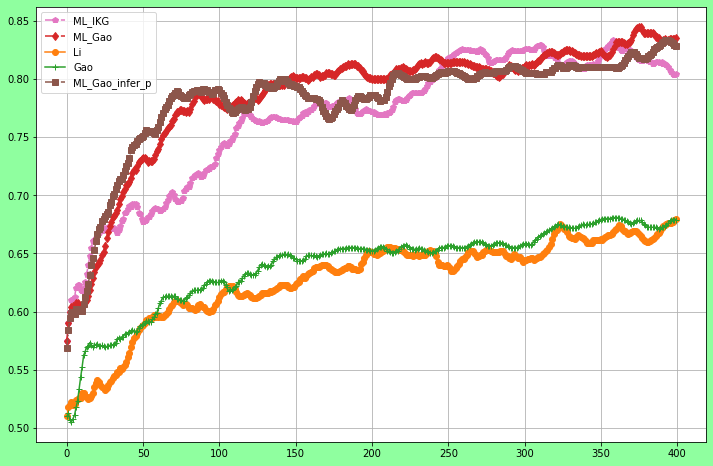

In [16]:
# _ = plot_experiment("config_g_3_mean")
_ = plot_experiment("config_g_3_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 140 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 20, 0, 20, 20, 0] outputs!


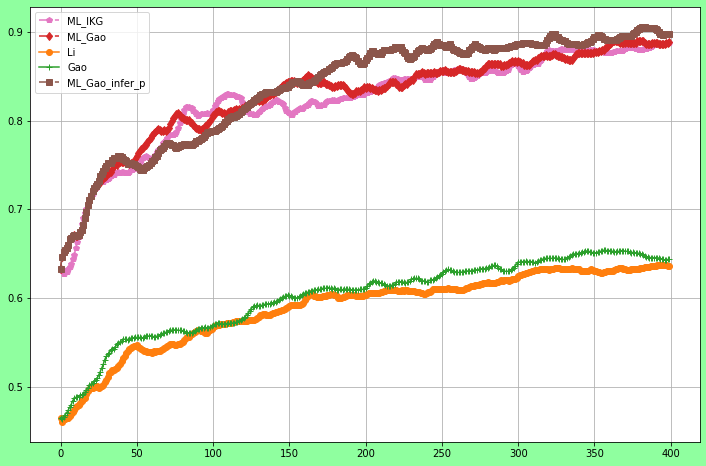

In [17]:
# _ = plot_experiment("config_g_4_mean")
_ = plot_experiment("config_g_4_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 200,
    "fit_frequency": 10,
    "num_arms": 20,
    "num_contexts": 40,
    "num_fantasies": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 97 output files.
Plotting [0, 19, 0, 20, 19, 19, 0, 0, 0, 0, 0, 0, 20, 0] outputs!


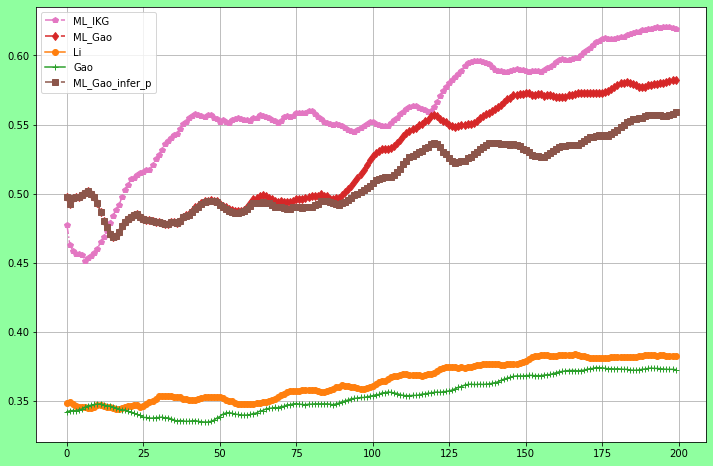

In [18]:
# _ = plot_experiment("config_g_5_mean")
_ = plot_experiment("config_g_5_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "rho_key": "cvar_0.5",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 158 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 20, 0, 20, 19, 19] outputs!


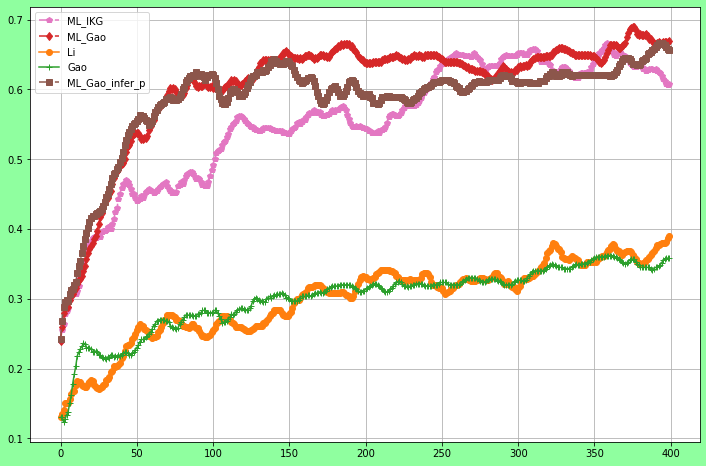

In [19]:
# _ = plot_experiment("config_g_3_cvar")
_ = plot_experiment("config_g_3_cvar", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "rho_key": "cvar_0.5",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 140 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 20, 0, 20, 20, 0] outputs!


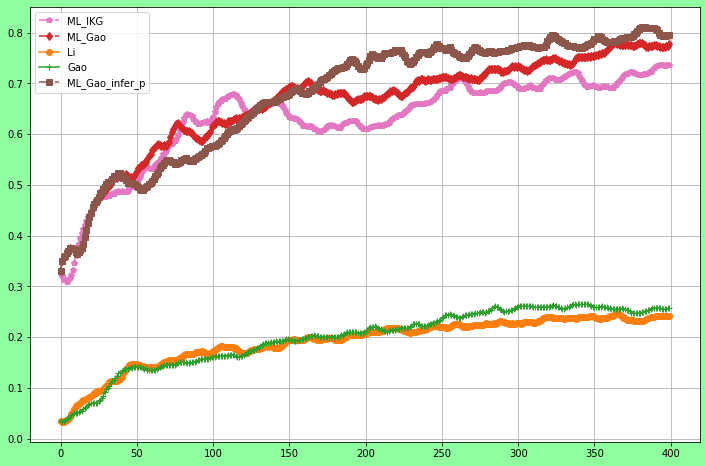

In [20]:
# _ = plot_experiment("config_g_4_cvar")
_ = plot_experiment("config_g_4_cvar", empirical_pcs=True)


Config: 
 {
    "iterations": 200,
    "fit_frequency": 10,
    "num_arms": 20,
    "num_contexts": 40,
    "num_fantasies": 0,
    "rho_key": "cvar_0.5",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 67 output files.
Plotting [0, 8, 0, 20, 7, 12, 0, 0, 0, 0, 0, 0, 20, 0] outputs!


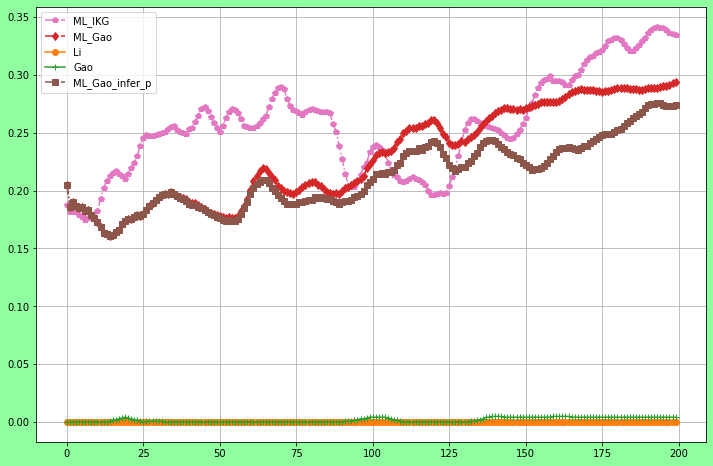

In [21]:
# _ = plot_experiment("config_g_5_cvar")
_ = plot_experiment("config_g_5_cvar", empirical_pcs=True)

Config: 
 {
    "iterations": 100,
    "fit_frequency": 10,
    "num_arms": 4,
    "num_contexts": 10,
    "num_fantasies": 0,
    "rho_key": "worst",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 98 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 18] outputs!


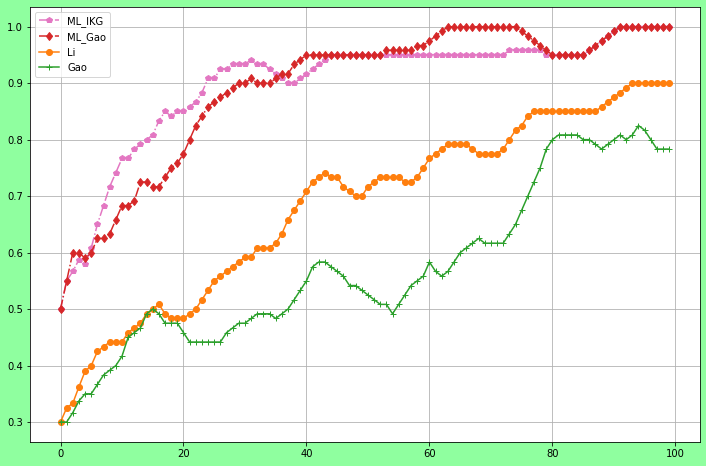

In [22]:
# _ = plot_experiment("config_b_2_worst")
_ = plot_experiment("config_b_2_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "rho_key": "worst",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 139 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 20, 0, 20, 19, 0] outputs!


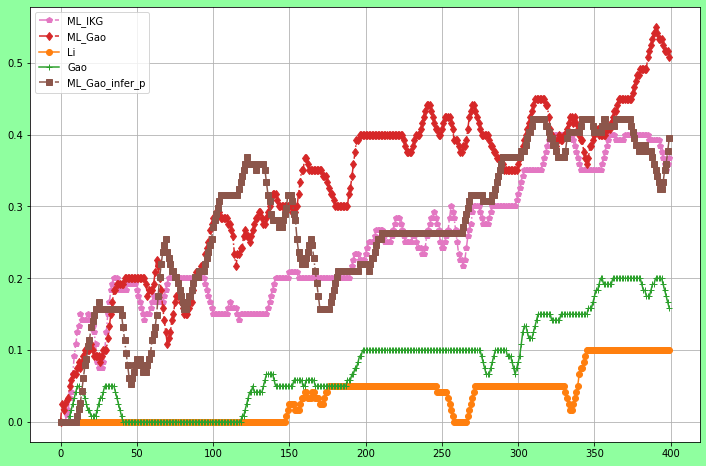

In [23]:
# _ = plot_experiment("config_b_3_worst")
_ = plot_experiment("config_b_3_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "rho_key": "worst",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 140 output files.
Plotting [0, 0, 0, 20, 20, 20, 0, 0, 0, 20, 0, 20, 20, 0] outputs!


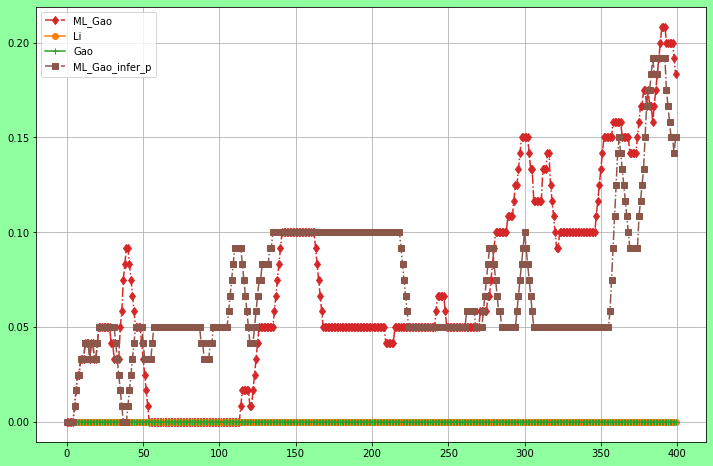

In [24]:
# _ = plot_experiment("config_b_4_worst")
_ = plot_experiment("config_b_4_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 200,
    "fit_frequency": 10,
    "num_arms": 20,
    "num_contexts": 40,
    "num_fantasies": 0,
    "rho_key": "worst",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 75 output files.
Plotting [0, 18, 0, 18, 19, 20, 0, 0, 0, 0, 0, 0, 0, 0] outputs!


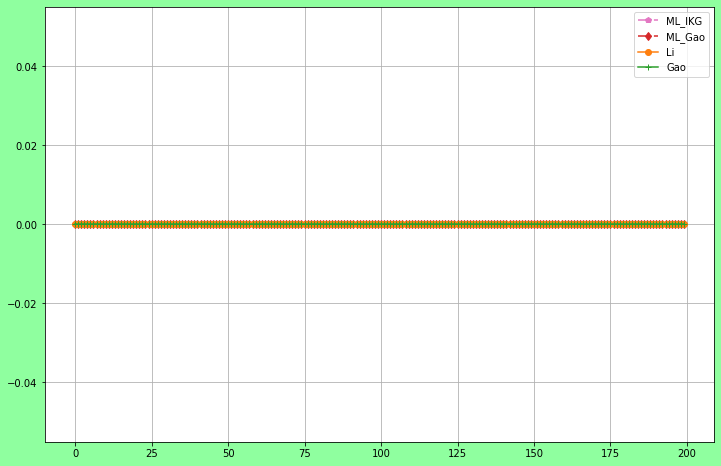

In [25]:
# _ = plot_experiment("config_b_5_worst")
_ = plot_experiment("config_b_5_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 139 output files.
Plotting [0, 20, 0, 20, 20, 20, 0, 0, 0, 19, 0, 20, 20, 0] outputs!


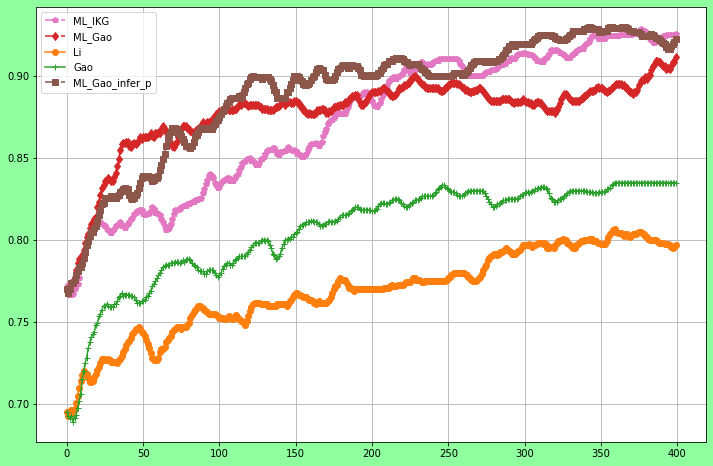

In [26]:
# _ = plot_experiment("config_b_3_mean")
_ = plot_experiment("config_b_3_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "context_dim": 2,
    "num_fantasies": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "hartmann"
    }
}
Found 138 output files.
Plotting [0, 19, 0, 19, 20, 20, 0, 0, 0, 20, 0, 20, 20, 0] outputs!


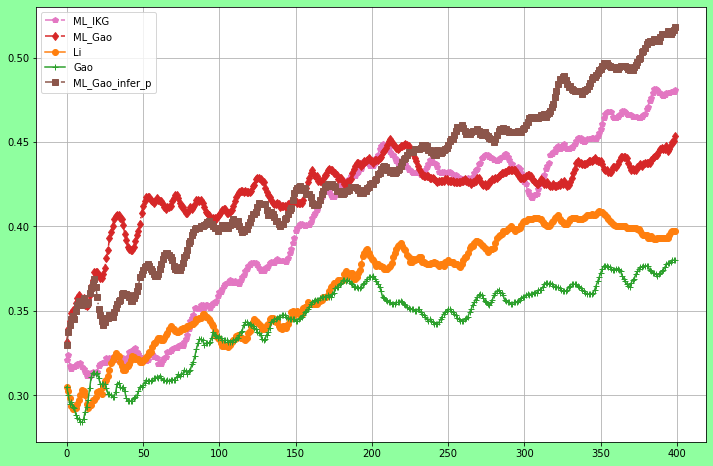

In [27]:
# _ = plot_experiment("config_h_3_mean")
_ = plot_experiment("config_h_3_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "context_dim": 2,
    "num_fantasies": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "hartmann"
    }
}
Found 89 output files.
Plotting [0, 19, 0, 15, 19, 20, 0, 0, 0, 0, 0, 0, 16, 0] outputs!


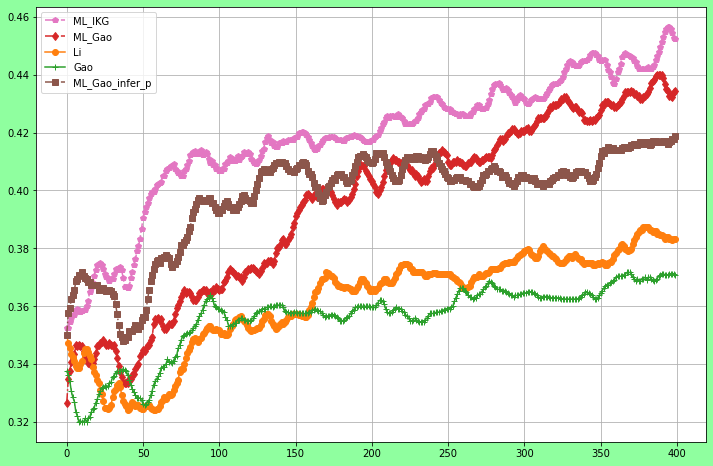

In [28]:
# _ = plot_experiment("config_h_4_mean")
_ = plot_experiment("config_h_4_mean", empirical_pcs=True)